Importing the Essential Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


Discriminator Block

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,in_features):
    super().__init__()
    self.disc=nn.Sequential(
        nn.Linear(in_features,128),
        nn.LeakyReLU(0.01),
        nn.Linear(128,1),
        nn.Sigmoid(),
    )

  def forward(self,x):
    return self.disc(x)



Generator Block

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim,img_dim):
    super().__init__()
    self.gen=nn.Sequential(
        nn.Linear(z_dim,256),
        nn.LeakyReLU(0.01),
        nn.Linear(256,img_dim),
        nn.Tanh(),
    )
  def forward(self,x):
    return self.gen(x)



The device is used to Specify where the computatios should be done either the cpu are the Gpu

In [ ]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50

In [ ]:
fixed_noise = torch.randn((batch_size, z_dim)).to(device)


In [ ]:
print(fixed_noise.shape)

torch.Size([32, 64])


In [ ]:
print(fixed_noise)

tensor([[-0.3534, -1.8301,  0.1081,  ...,  0.6434, -0.2750,  1.0755],
        [ 0.8131,  0.8235, -3.0663,  ..., -1.1956, -0.4995,  0.6794],
        [-0.5307, -0.2315,  0.6502,  ...,  1.2649,  0.0963,  1.6428],
        ...,
        [ 0.4858,  0.2851,  2.0896,  ...,  0.0959,  0.1026,  1.6414],
        [-1.1844,  0.8338, -0.4473,  ...,  1.8827,  0.2663,  0.3135],
        [-1.1871, -0.4008,  1.1875,  ..., -0.0631,  1.0327, -0.2834]],
       device='cuda:0')


In [ ]:
gen = Generator(z_dim, image_dim).to(device)

print(gen(fixed_noise).shape)

torch.Size([32, 784])


**transforms.ToTensor()**: This converts the image data into a PyTorch tensor. This is a necessary step because PyTorch works with tensors as input data rather than raw image data.
**transforms.Normalize((0.1307,), (0.3881,))**: This normalizes the tensor image with mean and standard deviation. The first tuple (0.1307,) represents the mean for each channel, and the second tuple (0.3881,) represents the standard deviation for each channel. These values are often pre-calculated statistics from the dataset you're working with or are commonly used statistics for standard datasets.[link text](https://)

In [ ]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3881,)),
    ]
)

**DataLoader(dataset, batch_size=batch_size, shuffle=True):**
 This creates a data loader object. It helps in iterating over the dataset in batches during training. Parameters like batch_size determine the number of samples in each batch, and shuffle=True indicates that the data will be shuffled randomly before each epoch to ensure the model doesn't overfit to the order of the data.

In [ ]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 17762949.64it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 481957.55it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 1534581.64it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 2396292.93it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
for batch_idx, (real, _) in enumerate(loader):


  noise = torch.randn(batch_size, z_dim).to(device)
  print("noice shape ",noise.shape)
  fake = gen(noise)
  print("Fake dim",fake.shape)


  real = real.view(-1, 784).to(device)
  batch_size = real.shape[0]
  print("real shape",real.shape)

  disc_real = disc(real).view(-1)
  print(disc_real.shape)
  disc_fake = disc(fake).view(-1)
  print(disc_fake.shape)
  break

noice shape  torch.Size([32, 64])
Fake dim torch.Size([32, 784])
real shape torch.Size([32, 784])
torch.Size([32])
torch.Size([32])


In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)

        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )

Epoch [0/50] Batch 0/1875                       Loss D: 0.6849, loss G: 0.6674
Epoch [1/50] Batch 0/1875                       Loss D: 0.1046, loss G: 2.2234
Epoch [2/50] Batch 0/1875                       Loss D: 0.0928, loss G: 2.8732
Epoch [3/50] Batch 0/1875                       Loss D: 0.1053, loss G: 2.8545
Epoch [4/50] Batch 0/1875                       Loss D: 0.0359, loss G: 3.8849
Epoch [5/50] Batch 0/1875                       Loss D: 0.1486, loss G: 3.1829
Epoch [6/50] Batch 0/1875                       Loss D: 0.1530, loss G: 4.3162
Epoch [7/50] Batch 0/1875                       Loss D: 0.0909, loss G: 4.4837
Epoch [8/50] Batch 0/1875                       Loss D: 0.0532, loss G: 4.4174
Epoch [9/50] Batch 0/1875                       Loss D: 0.0706, loss G: 4.3341
Epoch [10/50] Batch 0/1875                       Loss D: 0.0261, loss G: 4.8784
Epoch [11/50] Batch 0/1875                       Loss D: 0.0489, loss G: 4.7054
Epoch [12/50] Batch 0/1875                       L

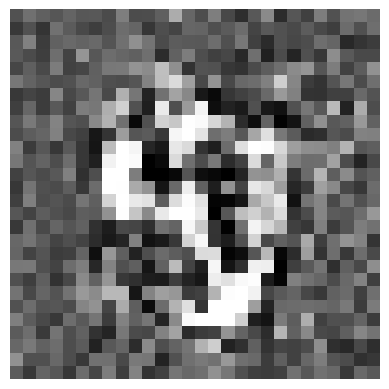

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random noise
new_noise = torch.randn((1, z_dim)).to(device)

# Pass noise through the generator
with torch.no_grad():
    generated_image = gen(new_noise).reshape(1, 1, 28, 28)  # Reshape to match MNIST image dimensions

# Convert tensor to numpy array and then to an image
generated_image = generated_image.cpu().detach().numpy()  # Move to CPU and detach from gradients
generated_image = np.squeeze(generated_image)  # Remove single-dimensional entries from the shape of an array

# Display the generated image
plt.imshow(generated_image, cmap='gray')
plt.axis('off')
plt.show()
